# Barataria LSTM Test1 - March 2023 - WL


## 0. Imports

In [9]:
# Import Mikey Scripts
'''
%cd ../USGS_DataImporter
from retrieve_data import *
from streamflow_ML import *

%cd ../Barataria-Ahmed
'''

# Import common modules for processing and plotting data
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

import datetime

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd

# For LSTM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import mean_squared_error

# To plot pretty figures <3
%matplotlib inline
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    

In [10]:
N_NODES = 15

## 1. Data import and cleaning


In [11]:
# All 15 nodes, 2020 and 2021 data
# Read in data
barataria20_21 = pd.read_csv('2020_2021_Sample.csv')

# Subset data to 2020 and 2021
barataria20 = barataria20_21[barataria20_21['Year'] == 2020]
barataria21 = barataria20_21[barataria20_21['Year'] == 2021]

barataria20 = barataria20.copy()
barataria21 = barataria21.copy()

# Convert to datetime
barataria20['Day'] = barataria20.loc[:, 'Day'].apply(lambda x: x - 1)
barataria21['Day'] = barataria21.loc[:, 'Day'].apply(lambda x: x - 1)

barataria20['datetime'] = pd.to_datetime(barataria20.loc[:, 'Day'], unit='D', origin= str(2020))
barataria21['datetime'] = pd.to_datetime(barataria21.loc[:, 'Day'], unit='D', origin= str(2021))

#Synchronization value: The number of days until stability
#(i.e. the number of days until Water Level is stable)
sync_value = 14

barataria20 = barataria20[barataria20['Day'] >= sync_value]
barataria21 = barataria21[barataria21['Day'] >= sync_value]

#Merge 2020 and 2021 data
barataria20_21 = barataria20.merge(barataria21, how= 'outer')

#Set datetime as index
barataria20_21 = barataria20_21.set_index('datetime')

In [12]:
# Delete unnecessary 
del barataria20_21['m']
del barataria20_21['n']
del barataria20_21['Lat']
del barataria20_21['Lon']

del barataria20_21['salinity']
del barataria20_21['Year']
del barataria20_21['Day']

# Delete Salinity Levels at each point
del barataria20_21['SL.B1']
del barataria20_21['SL.B2']
del barataria20_21['SL.B3']
del barataria20_21['SL.B4']
del barataria20_21['SL.B5']
del barataria20_21['SL.B6']
del barataria20_21['SL.B7']
del barataria20_21['SL.B8']

In [13]:
barataria20_21.columns

Index(['Point-ID', 'BL', 'WS', 'WD', 'Pressure', 'Precipitation',
       'Miss.Discharge', 'DP.Discharge', 'GIWW.Discharge', 'Naomi.Discharge',
       'Dist1', 'Dist2', 'Dist3', 'Dist4', 'Dist5', 'Dist6', 'Dist7', 'Dist8',
       'Dist9', 'WL.B1', 'WL.B2', 'WL.B3', 'WL.B4', 'WL.B5', 'WL.B6', 'WL.B7',
       'WL.B8', 'WL'],
      dtype='object')

In [14]:
'''
# Subset into independent df for each point.
nodes_df_dict = {}
for i in range(N_NODES + 1):
    nodes_df_dict.update({i : barataria20_21[barataria20_21['Point-ID'] == i]})
    
    
### NOTE ###
# Since Point-ID Starts at 1, nodes_df_dict also start at 1. So the firs node df begins at 1.
node_1 = nodes_df_dict[1]
del node_1['salinity']
del node_1['Year']
del node_1['Day']
'''

"\n# Subset into independent df for each point.\nnodes_df_dict = {}\nfor i in range(N_NODES + 1):\n    nodes_df_dict.update({i : barataria20_21[barataria20_21['Point-ID'] == i]})\n    \n    \n### NOTE ###\n# Since Point-ID Starts at 1, nodes_df_dict also start at 1. So the firs node df begins at 1.\nnode_1 = nodes_df_dict[1]\ndel node_1['salinity']\ndel node_1['Year']\ndel node_1['Day']\n"

C:\Users\perso\AppData\Local\Temp\ipykernel_24216\2154436680.py:5: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df.loc[f"{tstart}":f"{tstart}", "WL"].plot(figsize=(16, 4), legend=True)
C:\Users\perso\AppData\Local\Temp\ipykernel_24216\2154436680.py:6: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df.loc[f"{tend}":f"{tend}", "WL"].plot(figsize=(16, 4), legend=True)


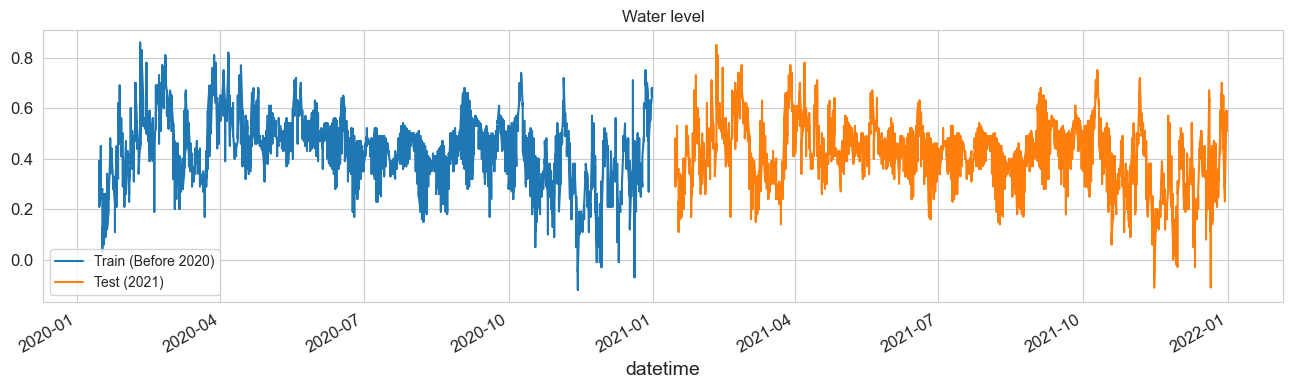

In [15]:
# Plot data
tstart = 2020
tend = 2021
def train_test_plot(df, tstart, tend):
    df.loc[f"{tstart}":f"{tstart}", "WL"].plot(figsize=(16, 4), legend=True)
    df.loc[f"{tend}":f"{tend}", "WL"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tstart})", f"Test ({tend})"])
    plt.title("Water level")
    plt.show()

train_test_plot(barataria20_21,tstart,tend)


## Model LSTM

In [16]:
# Subset the train/testing data
# Train: 2017-2018, 2020
# Test: 2019, 2021

train = barataria20_21[:'2021'] # Everything up to 2021
test = barataria20_21['2021':'2022'] # Year of 2021

C:\Users\perso\AppData\Local\Temp\ipykernel_24216\3128609601.py:6: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test = barataria20_21['2021':'2022'] # Year of 2021


## Data manipulation

In [17]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(train)
train_scaled = scaler.transform(train)

In [18]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.
# We will make timesteps = 7 (past 7 days data used for training).

#Empty lists to be populated using formatted training data
trainX = []
trainY = []



n_future = 1 # Number of timesteps we want to look into the future based on the past timesteps. Just one day ahead
n_past = 7 # Number of past timesteps we want to use to predict the future. Use past 7 days.

#Reformat input data into a shape: (n_samples x timesteps x n_features) x pointID ?
#In the example, df_for_training_scaled has a shape (10538 / 15, 7, 28) x 15
#10538 refers to the number of data points and 28 refers to the columns (multi-variables).

#NEW df has a shape (10538 / 15 = 702, 15, 7, 28)


# prediction


for i in range(n_past, len(train_scaled) - n_future + 1):
    trainX.append(train_scaled[i - n_past : i, 0 : train_scaled.shape[1]])
    trainY.append(train_scaled[i + n_future - 1 : i + n_future, -1]) #-1 = WL (last col in df)

trainX, trainY = np.array(trainX), np.array(trainY)


print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (10538, 7, 28).
trainY shape == (10538, 1).


In [28]:
trainX[0]

array([[-1.62018517,  1.00988417, -0.77098881, -1.07216629,  2.67985114,
        -0.48965544, -0.73438041, -0.75411988,  0.08845403, -0.36715497,
        -0.80699989, -0.80691177,  0.84971197,  0.66974323,  0.84057601,
         0.82407096,  0.80692736,  0.80692601,  0.80691969, -0.85631382,
        -0.72703114, -0.64221222, -0.58851924, -0.65873236, -0.72745443,
        -0.71509578, -0.75074685, -1.6470435 ],
       [-1.62018517,  1.00988417, -1.28193692, -0.3758153 ,  2.06473188,
        -0.48965544, -0.68936201, -0.70654753, -0.36112269, -0.36715497,
        -0.80699989, -0.80691177,  0.84971197,  0.66974323,  0.84057601,
         0.82407096,  0.80692736,  0.80692601,  0.80691969, -1.85141554,
        -1.77202344, -1.69975056, -1.64467691, -1.7255717 , -1.86530191,
        -1.88477518, -1.98167371, -1.34805404],
       [-1.62018517,  1.00988417,  2.77341275, -1.77783105,  3.42245872,
        -0.18328799, -0.64678248, -0.66155239, -1.60972876, -0.36715497,
        -0.80699989, -0.8069

In [20]:
print(trainX[0])

[[-1.62018517  1.00988417 -0.77098881 -1.07216629  2.67985114 -0.48965544
  -0.73438041 -0.75411988  0.08845403 -0.36715497 -0.80699989 -0.80691177
   0.84971197  0.66974323  0.84057601  0.82407096  0.80692736  0.80692601
   0.80691969 -0.85631382 -0.72703114 -0.64221222 -0.58851924 -0.65873236
  -0.72745443 -0.71509578 -0.75074685 -1.6470435 ]
 [-1.62018517  1.00988417 -1.28193692 -0.3758153   2.06473188 -0.48965544
  -0.68936201 -0.70654753 -0.36112269 -0.36715497 -0.80699989 -0.80691177
   0.84971197  0.66974323  0.84057601  0.82407096  0.80692736  0.80692601
   0.80691969 -1.85141554 -1.77202344 -1.69975056 -1.64467691 -1.7255717
  -1.86530191 -1.88477518 -1.98167371 -1.34805404]
 [-1.62018517  1.00988417  2.77341275 -1.77783105  3.42245872 -0.18328799
  -0.64678248 -0.66155239 -1.60972876 -0.36715497 -0.80699989 -0.80691177
   0.84971197  0.66974323  0.84057601  0.82407096  0.80692736  0.80692601
   0.80691969 -1.39735989 -1.34814189 -1.23212695 -1.18163846 -1.31001698
  -1.492773

### LSTM architecture

In [21]:
# The LSTM architecture -- Basic RNN | one layer then dense
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(trainX.shape[1], trainX.shape[2])))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               77000     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 77,126
Trainable params: 77,126
Non-trainable params: 0
_________________________________________________________________


In [17]:
batch_size = 16 # Change to 64 as per paper

model_lstm.fit(trainX, trainY, epochs=10, batch_size=batch_size, verbose=1)


Epoch 1/10
659/659 [==============================] - 6s 5ms/step - loss: 0.2553
Epoch 2/10
659/659 [==============================] - 3s 5ms/step - loss: 0.1308
Epoch 3/10
659/659 [==============================] - 3s 5ms/step - loss: 0.0721
Epoch 4/10
659/659 [==============================] - 3s 5ms/step - loss: 0.0469
Epoch 5/10
659/659 [==============================] - 3s 5ms/step - loss: 0.0339
Epoch 6/10
659/659 [==============================] - 3s 5ms/step - loss: 0.0260
Epoch 7/10
659/659 [==============================] - 4s 6ms/step - loss: 0.0207
Epoch 8/10
659/659 [==============================] - 4s 5ms/step - loss: 0.0171
Epoch 9/10
659/659 [==============================] - 3s 5ms/step - loss: 0.0149
Epoch 10/10
659/659 [==============================] - 4s 6ms/step - loss: 0.0136


In [ ]:
# Save the entire model as a SavedModel.
'''
!mkdir -p saved_model
model_lstm.save('saved_model/LSTM_Saved_Barataria_WL_2020_2021')
'''

In [22]:
model_lstm = tf.keras.models.load_model('./saved_model/LSTM_Saved_Barataria_WL_2020_2021')

### Predictions


In [23]:
testX = []
testY = []

n_future = 1 # Number of timesteps we want to look into the future based on the past timesteps. Just one day ahead
n_past = 7 # Number of past timesteps we want to use to predict the future. Use past 7 days.

scaler2 = StandardScaler() # Scaling the test data to fit the same way as the training
scaler2 = scaler2.fit(test)
test_scaled = scaler2.transform(test)

# Reformat the testing data to fit the format of the LSTM expected inputs.

for i in range(n_past, len(test_scaled) - n_future +1):
    testX.append(test_scaled[i - n_past:i, 0:test_scaled.shape[1]])
    testY.append(test_scaled[i + n_future - 1:i + n_future, -1])

testX, testY = np.array(testX), np.array(testY)


## Future Dates Prediction

In [14]:
# Run test
# Prediction
#pred_WL = model_lstm.predict(testX)
n_future_pred = 14
overlap = 1
pred_WL = model_lstm.predict(trainX[-n_future_pred - overlap:])

1/1 [==============================] - 1s 899ms/step


<Axes: xlabel='datetime', ylabel='WL'>

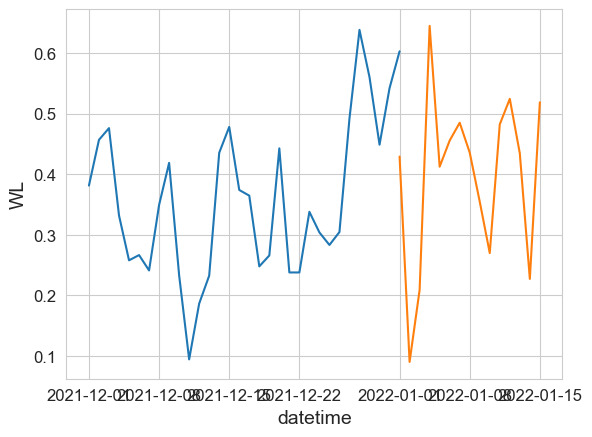

In [15]:
import seaborn as sns

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 27 times and discard them after inverse transform
prediction_copies = np.repeat(pred_WL, train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,-1]

predict_period_dates = pd.date_range(list(barataria20_21.index)[-overlap],periods=n_future_pred + overlap, freq='D').tolist()

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
len(y_pred_future)

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'WL':y_pred_future})

df_forecast.set_index('Date', inplace= True)

original = barataria20_21[['WL']]
original = original.loc['2021-12': '2022']

sns.lineplot(original['WL'], errorbar= None)
sns.lineplot(df_forecast['WL'],errorbar= None)

## Compare with Large Dataset

In [ ]:
# All 15 nodes, 2020 and 2021 data
# Read in data
barataria_full = pd.read_csv('Final_Dataset.csv')


# Convert to datetime
barataria_full['Day'] = barataria_full.loc[:, 'Day'].apply(lambda x: x - 1)

barataria_full['datetime'] = barataria_full.loc[:,'Day']
#pd.to_datetime(barataria_full.loc[:, 'Day'], unit='D')

#Synchronization value: The number of days until stability
#(i.e. the number of days until Water Level is stable)
sync_value = 14

barataria_full = barataria_full[barataria_full['Day'] >= sync_value]

#Merge 2020 and 2021 data

#Set datetime as index
#barataria_full = barataria_full.set_index('datetime')

In [ ]:
pd.to_datetime(barataria_full)

## Testing

In [24]:
pred_WL_full = model_lstm.predict(testX)

# Change into DF and adjust for the 7 days initial period
test_predicts = test[:-n_past].copy()
test_predicts["Predicted WL"] = pred_WL_full
test_predicts.rename(columns= {0 : "Predicted WL"})
test_predicts = test_predicts.drop("WL", axis=1)

# Inverse transform the values using minmax scaler
predictions = scaler2.inverse_transform(test_predicts)
predictions = pd.DataFrame(predictions).rename(columns= {27 : 'Predicted WL'})['Predicted WL']
test_predicts["Transformed WL"] = predictions.values


165/165 [==============================] - 1s 5ms/step


In [26]:
test_predicts

,Point-ID,BL,WS,WD,Pressure,Precipitation,Miss.Discharge,DP.Discharge,GIWW.Discharge,Naomi.Discharge,...,WL.B1,WL.B2,WL.B3,WL.B4,WL.B5,WL.B6,WL.B7,WL.B8,Predicted WL,Transformed WL
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-15,1,-2.13499,3.078986,70.343639,102331.367188,0.000000,21204.435547,106.174532,65.21,0.0,...,0.328151,0.291461,0.266888,0.254763,0.284714,0.328674,0.390222,0.398150,0.308607,0.462042
2021-01-16,1,-2.13499,1.827750,134.078928,102059.250000,0.000000,21428.725049,107.297591,46.89,0.0,...,0.224189,0.185741,0.159651,0.153709,0.180247,0.225488,0.276044,0.260675,0.356864,0.468268
2021-01-17,1,-2.13499,11.758701,5.755885,102659.882812,0.088685,21880.597095,109.560198,-3.99,0.0,...,0.260371,0.214557,0.198053,0.194387,0.210225,0.263267,0.292401,0.197048,-0.324672,0.380343
2021-01-18,1,-2.13499,8.149099,35.014081,102889.382812,0.000000,22269.786499,111.508941,11.58,0.0,...,0.156452,0.122808,0.100444,0.093979,0.125298,0.174769,0.224467,0.188580,-0.826411,0.315614
2021-01-19,1,-2.13499,3.945247,51.738076,102241.890625,0.000000,22614.328345,113.234126,61.17,0.0,...,0.133917,0.096222,0.068345,0.063333,0.089244,0.138885,0.192607,0.193032,-0.708349,0.330845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-21,15,-3.36399,16.066622,312.104881,99869.062500,0.985822,5961.406253,29.849864,128.40,0.0,...,0.368924,0.355573,0.344280,0.343683,0.355893,0.370800,0.379315,0.354240,0.661384,0.507554
2021-12-22,15,-3.36399,3.518531,298.984345,101159.875000,0.000000,6002.723193,30.056746,108.96,0.0,...,0.341696,0.312265,0.294518,0.290387,0.303415,0.317764,0.328882,0.344696,0.071631,0.431470
2021-12-23,15,-3.36399,7.641140,189.737193,101381.742188,0.000000,5994.835889,30.017252,104.85,0.0,...,0.180455,0.162314,0.140737,0.139233,0.155783,0.164035,0.173614,0.204113,-1.473974,0.232073


<Axes: xlabel='datetime', ylabel='WL'>

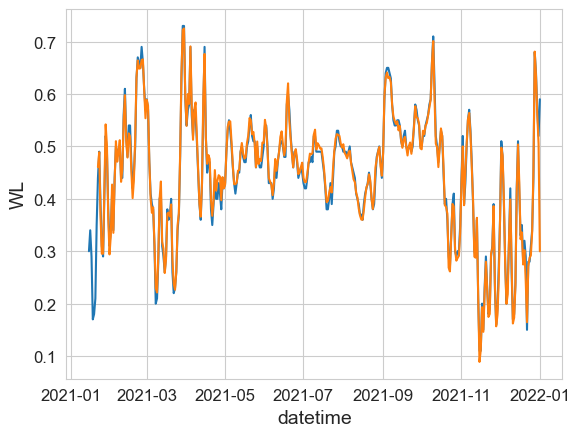

In [16]:
import seaborn as sns
#Plot for point 5
point = 5

sns.lineplot(test['WL'][test['Point-ID'] == point], errorbar= None)
sns.lineplot(test_predicts['Transformed WL'][test_predicts['Point-ID'] == point].shift(7), errorbar= None)
# shifting 7 to overlay due to inherent shifting from original formatting of the data.



In [17]:
# MSE for all points.
mean_squared_error(test["WL"][:-7], test_predicts["Transformed WL"])


0.0251860822531395

In [5]:
test_predicts

NameError: name 'test_predicts' is not defined